# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.metrics  import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.metrics import fbeta_score, plot_roc_curve, matthews_corrcoef, make_scorer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import warnings
import sys
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')  
warnings.filterwarnings("ignore", category=RuntimeWarning) 
sys.path.append("../scripts/")
from helper import *
from evaluate_model import *

In [2]:
path_raw_data = '../raw_data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
path_cleaned_data = '../data/Kaggle_Sirio_Libanes_ICU_Prediction_reduced.csv'

data = pd.read_excel(path_raw_data)
cleaned_data = pd.read_csv(path_cleaned_data)

pacient_id = ['PATIENT_VISIT_IDENTIFIER']
demographic_columns = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER']
preexisting_disease_columns = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER']
blood_results = ['ALBUMIN', 'BE_ARTERIAL', 'BE_VENOUS', 'BIC_ARTERIAL', 'BIC_VENOUS', 'BILLIRUBIN', 'BLAST', 'CALCIUM', 'CREATININ', 'FFA', 'GGT', 'GLUCOSE', 'HEMATOCRITE', 'HEMOGLOBIN', 'INR', 'LACTATE', 'LEUKOCYTES', 'LINFOCITOS', 'NEUTROPHILES', 'P02_ARTERIAL', 'P02_VENOUS', 'PC02_ARTERIAL', 'PC02_VENOUS', 'PCR', 'PH_ARTERIAL', 'PH_VENOUS', 'PLATELETS', 'POTASSIUM', 'SAT02_ARTERIAL', 'SAT02_VENOUS', 'SODIUM', 'TGO', 'TGP', 'TTPA', 'UREA', 'DIMER']
status_columns = ['WINDOW', 'ICU']

attributes_suffix = ['DIFF', 'DIFF_REL', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
vital_signs = ['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE', 'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE']
vital_signs_columns = [f'{vs}_{attr}'for vs in vital_signs for attr in attributes_suffix]

In [3]:
cleaned_data[preexisting_disease_columns] = cleaned_data[preexisting_disease_columns].astype('bool')
cleaned_data[['AGE_ABOVE65', 'GENDER']] = cleaned_data[['AGE_ABOVE65', 'GENDER']].astype('bool')
cleaned_data['AGE_PERCENTIL'] = cleaned_data['AGE_PERCENTIL'].astype("category").cat.codes
cleaned_data['WINDOW'] = cleaned_data['WINDOW'].astype("category")#.cat.codes
# cleaned_data['ICU'] = cleaned_data['ICU'].astype('bool')
cleaned_data.head()#describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,SAT02_ARTERIAL,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER,WINDOW,ICU
0,0,True,5,False,False,False,False,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
1,0,True,5,False,False,False,False,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
2,0,True,5,False,False,False,False,False,True,True,...,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,4-6,0
3,0,True,5,False,False,False,False,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,0
4,0,True,5,False,False,False,False,False,True,True,...,0.848485,0.925926,0.142857,-0.999067,-0.983994,-0.846633,-0.836145,-0.996762,ABOVE_12,1


# COVID-19 - Dados clínicos para avaliação de diagnóstico

## Context
COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources.
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20.

### Call to action
There is urgency in obtaining accurate that to better predict and prepare healthcare systems and avoid collapse, defined by above capacity need of ICU beds (assuming human resources, PPE and professionals are available), using individual clinical data - in lieu of epidemiological and populational data.

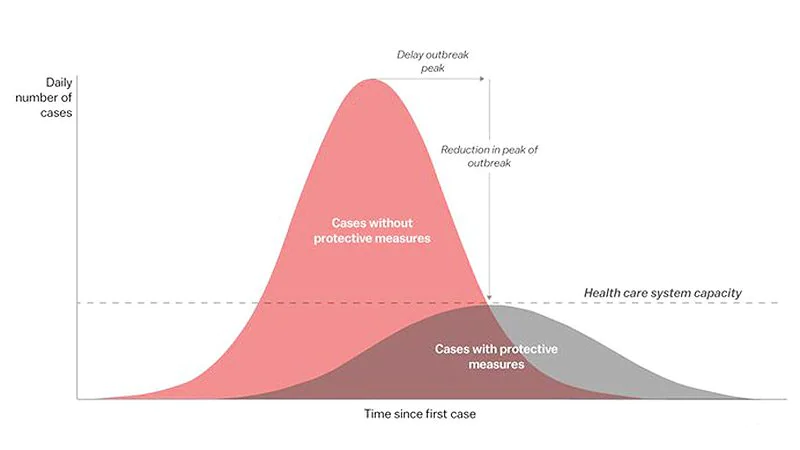

#### Task 01
Predict admission to the ICU of confirmed COVID-19 cases.
Based on the data available, is it feasible to predict which patients will need intensive care unit support?
The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled.

#### Task 02
Predict NOT admission to the ICU of confirmed COVID-19 cases.
Based on the subsample of widely available data, is it feasible to predict which patients will need intensive care unit support?
The aim is to provide local and temporary hospitals a good enough answer, so frontline physicians can safely discharge and remotely follow up with these patients.

### Summary
Então, tão importante quanto saber se o paciente precisa de UTI, é garantir que o qual não precisa de UTI está correto.

## Data

### Label output
ICU should be considered, as the first version of this dataset, the target variable.

### Window Concept
We were carefull to include real life cenarios of with window of events and available data.
Data was obtain and grouped

* patient
** patient encounter
** aggregated by windows in chronological order

| Window | Description |
|------|------|
| 2-4 | From 2 to 4 hours of the admission |
| 0-2 | From 0 to 2 hours of the admission |
| 4-6 | From 4 to 6 hours of the admission |
| 6-12 | From 6 to 12 hours of the admission |
| Above-12 | Above 12 hours from admission |

** Beware NOT to use the data when the target variable is present, as it is unknown the order of the event (maybe the target event happened before the results were obtained). They were kept there so we can grow this dataset in other outcomes latter on.

Examples:

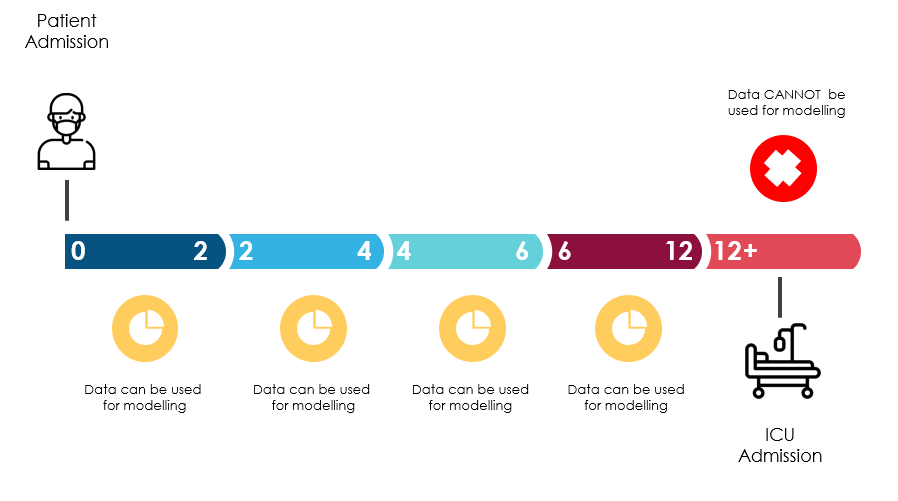
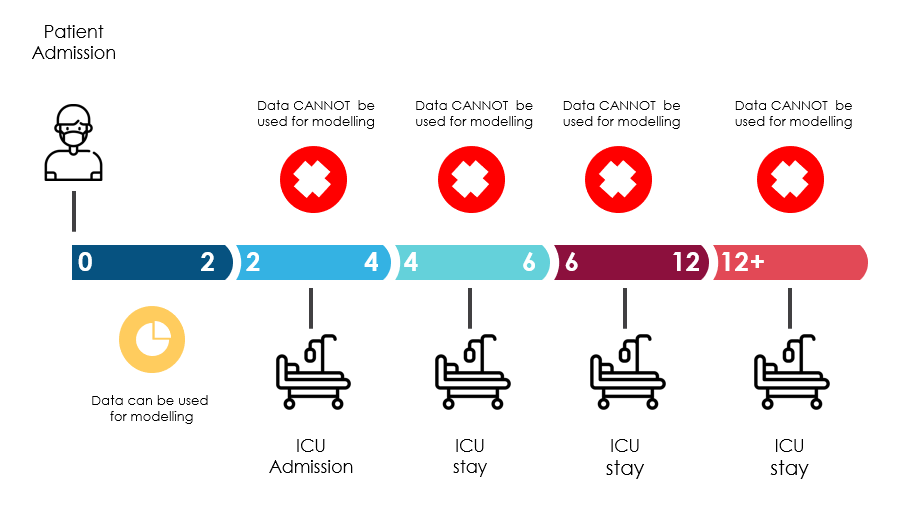

### Tips & Tricks
#### Missing data
Problem: One of the major challenges of working with health care data is that the sampling rate varies across different type of measurements. For instance, vital signs are sampled more frequently (usually hourly) than blood labs (usually daily).

Tips & Tricks: It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, potentially presenting vital signs and blood labs similar to neighboring windows. Therefore, one may fill the missing values using the next or previous entry. Attention to multicollinearity and zero variance issues in this data when choosing your algorithm.

#### The earlier, the better!
Problem: Early identification of those patients who will develop an adverse course of illness (and need intensive care) is a key for an appropriate treatment (saving lives) and to managing beds and resources.

Tips & Tricks: Whereas a predictive model using all time windows will probably yield a greater accuracy, a nice model using *only the first (0-2)* is likely to be more clinically relevant. The creativity is very welcome though, please feel free with feature engineering and time windows. Attention to repeated measures on individuals once these values are (positively) correlated when playing around with data.

# Preparing the dataset

## Filling Data

Let's looks the data for vital signs and blood results:

Also, let's first focus on the first window only.

In [4]:
cleaned_data[['PATIENT_VISIT_IDENTIFIER'] + blood_results + ['WINDOW']].loc[cleaned_data['WINDOW'] == '0-2'].describe()

,PATIENT_VISIT_IDENTIFIER,ALBUMIN,BE_ARTERIAL,BE_VENOUS,BIC_ARTERIAL,BIC_VENOUS,BILLIRUBIN,BLAST,CALCIUM,CREATININ,...,PLATELETS,POTASSIUM,SAT02_ARTERIAL,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER
count,385.000000,172.000000,172.0,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,...,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,192.000000,0.598378,-1.0,-0.969743,-0.324163,-0.339762,-0.945424,-0.998486,0.322081,-0.880815,...,-0.517481,-0.552110,0.929704,0.293641,-0.111517,-0.992598,-0.986338,-0.839337,-0.842225,-0.947486
std,111.284171,0.050078,0.0,0.079774,0.048259,0.105033,0.028824,0.019858,0.095041,0.156887,...,0.195637,0.199642,0.115853,0.347083,0.217534,0.024177,0.018309,0.041195,0.119613,0.166005
min,0.000000,0.210526,-1.0,-1.000000,-0.756098,-1.000000,-0.992674,-1.000000,-0.122449,-0.967445,...,-0.903872,-0.962963,-0.575758,-0.925926,-0.714286,-0.999627,-0.999619,-0.961853,-0.966265,-1.000000
25%,96.000000,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.962323,-1.000000,0.357143,-0.920736,...,-0.636849,-0.666667,0.939394,0.345679,-0.257143,-0.996827,-0.994379,-0.846633,-0.890361,-0.984003
50%,192.000000,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.000000,0.357143,-0.904459,...,-0.554072,-0.555556,0.939394,0.345679,-0.085714,-0.995428,-0.987805,-0.846633,-0.867470,-0.978029
75%,288.000000,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.000000,0.357143,-0.878273,...,-0.427904,-0.481481,0.939394,0.345679,0.038095,-0.995148,-0.986662,-0.846633,-0.816867,-0.958332
max,384.000000,0.684211,-1.0,-0.528796,-0.317073,-0.073171,-0.771847,-0.739568,0.693878,1.000000,...,0.228304,0.629630,0.939394,1.000000,1.000000,-0.693944,-0.794970,-0.640327,0.450602,1.000000


In [5]:
cleaned_data[['PATIENT_VISIT_IDENTIFIER'] + vital_signs_columns + ['WINDOW']].loc[cleaned_data['WINDOW'] == '0-2'].describe()

,PATIENT_VISIT_IDENTIFIER,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_MAX,...,RESPIRATORY_RATE_MAX,RESPIRATORY_RATE_MEAN,RESPIRATORY_RATE_MEDIAN,RESPIRATORY_RATE_MIN,TEMPERATURE_DIFF,TEMPERATURE_DIFF_REL,TEMPERATURE_MAX,TEMPERATURE_MEAN,TEMPERATURE_MEDIAN,TEMPERATURE_MIN
count,385.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,117.000000,117.000000,117.000000,117.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,192.000000,-0.979435,-0.982552,-0.343939,-0.065820,-0.064342,0.096847,-0.977430,-0.977368,-0.491813,...,-0.479409,-0.428178,-0.417919,-0.336386,-0.985558,-0.985453,-0.052507,0.156971,0.157201,0.474329
std,111.284171,0.065489,0.056424,0.192116,0.276801,0.281706,0.233779,0.072578,0.070531,0.232756,...,0.267766,0.292359,0.299286,0.308520,0.057801,0.059305,0.253460,0.318907,0.320900,0.202983
min,0.000000,-1.000000,-1.000000,-0.760684,-0.654321,-0.679012,-0.422680,-1.000000,-1.000000,-0.870270,...,-0.939394,-0.932203,-0.931034,-0.857143,-1.000000,-1.000000,-0.565217,-0.803571,-0.803571,-0.318681
25%,96.000000,-1.000000,-1.000000,-0.470085,-0.234568,-0.234568,-0.051546,-1.000000,-1.000000,-0.664865,...,-0.636364,-0.593220,-0.586207,-0.500000,-1.000000,-1.000000,-0.268116,-0.098214,-0.098214,0.318681
50%,192.000000,-1.000000,-1.000000,-0.350427,-0.061728,-0.061728,0.092784,-1.000000,-1.000000,-0.535135,...,-0.575758,-0.525424,-0.517241,-0.428571,-1.000000,-1.000000,-0.072464,0.107143,0.116071,0.450549
75%,288.000000,-1.000000,-1.000000,-0.247863,0.086420,0.086420,0.237113,-1.000000,-1.000000,-0.351351,...,-0.393939,-0.322034,-0.379310,-0.285714,-1.000000,-1.000000,0.101449,0.357143,0.357143,0.598901
max,384.000000,-0.565217,-0.574091,0.384615,1.000000,1.000000,1.000000,-0.546012,-0.610018,0.405405,...,0.636364,0.830508,0.862069,1.000000,-0.547619,-0.519055,0.623188,1.000000,1.000000,1.000000


For both types, not all data is filled for the first window. For _blood retuls_, that are measured daily, we have only 172 measurements inside 385 pacients, while for _vital signs_, we have as low as 117.


As stated in 'Window concept', we cannot use data from when the paciant is int ICU state. As stated in _Tips & Tricks_, it is safe to assume that missing data stable paciants are likely to remain the same, so let's just use `ffill` and `bfill`. For now, let's remain using the simplest strategy.

In [6]:
def fill_data(df, columns_to_fill, groupby_columns = ['PATIENT_VISIT_IDENTIFIER', 'ICU']):
    df[columns_to_fill] = df.groupby(groupby_columns, as_index=False)[columns_to_fill].fillna(method='ffill').fillna(method='bfill')
    return df

simple_filled_data = fill_data(cleaned_data, blood_results)
simple_filled_data = fill_data(simple_filled_data, vital_signs_columns)

## Slicing data

### Slicing for only window 0-2

Let's create a new column for paciants that will be sent to ICU "has been in ICU?" or `HB_ICU`.

In [7]:
simple_filled_data['HB_ICU'] = 0

In [8]:
def select_window(rows, window):
    if(np.any(rows['ICU'])):
        rows.loc[lambda df: df['WINDOW'].isin(window), 'HB_ICU'] = 1
    return rows.loc[rows['WINDOW'].isin(window)]

data_window02 = simple_filled_data.groupby('PATIENT_VISIT_IDENTIFIER').apply(select_window, ['0-2']).reset_index(drop=True)

Also, since we cannot use data from patient that are already at ICU, we need to drop those rows.

In [9]:
data_window02 = data_window02[data_window02['ICU'] == 0]
data_window02

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER,WINDOW,ICU,HB_ICU
0,0,True,5,False,False,False,False,False,True,True,...,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0-2,0,1
2,2,False,0,False,False,False,False,False,False,False,...,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,0-2,0,1
3,3,False,3,True,False,False,False,False,False,False,...,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0-2,0,0
4,4,False,0,False,False,False,False,False,False,False,...,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0-2,0,0
5,5,False,0,False,False,False,False,False,False,False,...,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,0-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,380,False,3,True,False,False,False,False,False,False,...,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,0-2,0,1
381,381,True,9,False,False,False,False,False,False,False,...,0.345679,-0.314286,-0.998507,-0.995808,-0.846633,-0.855422,-0.978029,0-2,0,0
382,382,False,4,False,False,False,False,False,False,False,...,0.345679,-0.085714,-0.995428,-0.986662,-0.846633,-0.787952,-0.964461,0-2,0,1
383,383,False,3,True,False,False,False,False,False,False,...,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.937349,-0.978029,0-2,0,0


## Highly correlated columns

In [10]:
def list_high_correlate_columns(df, threashold = 0.9):
    cor_matrix = df.corr().abs()
    cor_list = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool)).stack().reset_index()
    cor_list.columns = ['level_0', 'level_1', 'correlation']
    return cor_list.loc[cor_list['correlation'] > threashold].reset_index(drop=True)

# hcc_simple_filled = list_high_correlate_columns(simple_filled_data)['level_1'].to_list()
hcc_window02 = list_high_correlate_columns(data_window02)['level_1'].to_list()
# print(hcc_simple_filled)
print(f'List of High correlated columns: {hcc_window02}')


List of High correlated columns: ['BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_MEAN', 'BLOODPRESSURE_SISTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MIN', 'BLOODPRESSURE_SISTOLIC_MIN', 'HEART_RATE_DIFF_REL', 'HEART_RATE_MEAN', 'HEART_RATE_MEDIAN', 'HEART_RATE_MIN', 'HEART_RATE_MEDIAN', 'HEART_RATE_MIN', 'HEART_RATE_MIN', 'OXYGEN_SATURATION_DIFF_REL', 'OXYGEN_SATURATION_MEAN', 'OXYGEN_SATURATION_MEDIAN', 'OXYGEN_SATURATION_MEDIAN', 'OXYGEN_SATURATION_MIN', 'OXYGEN_SATURATION_MIN', 'RESPIRATORY_RATE_DIFF_REL', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MEDIAN', 'RESPIRATORY_RATE_MEDIAN', 'RESPIRATORY_RATE_MIN', 'RESPIRATORY_RATE_MIN', 'TEMPERATURE_DIFF_REL', 'TEMPERATURE_MEAN', 'TEMPERATURE_MEDIAN', 'TEMPERATURE_MEDIAN', 'TEMPERATURE_MIN', 'TEMPERATURE_

# Models comparisson

## Models for Window 0-2

For window 0-2, the columns `PATIENT_VISIT_IDENTIFIER`, `WINDOW` and `ICU` can be dropped.

In [11]:
data_window02 = data_window02.drop(columns=['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU'])

In [12]:
x_columns = data_window02.columns[:-1]
x = data_window02[x_columns] # Entrada
y = data_window02['HB_ICU'] # saida

np.random.seed(73246)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

## Running Classifiers

In [13]:
names = ["Dummy", "K Neighbors", "Linear SVM", "RBF SVM", "Gaussian",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "GBC"]

classifiers = [
    DummyClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GradientBoostingClassifier()
#     GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#     GradientBoostingClassifier(learning_rate=0.5, max_depth=8, max_features=0.4, min_samples_leaf=3, min_samples_split=17, n_estimators=100, subsample=1.0)
]

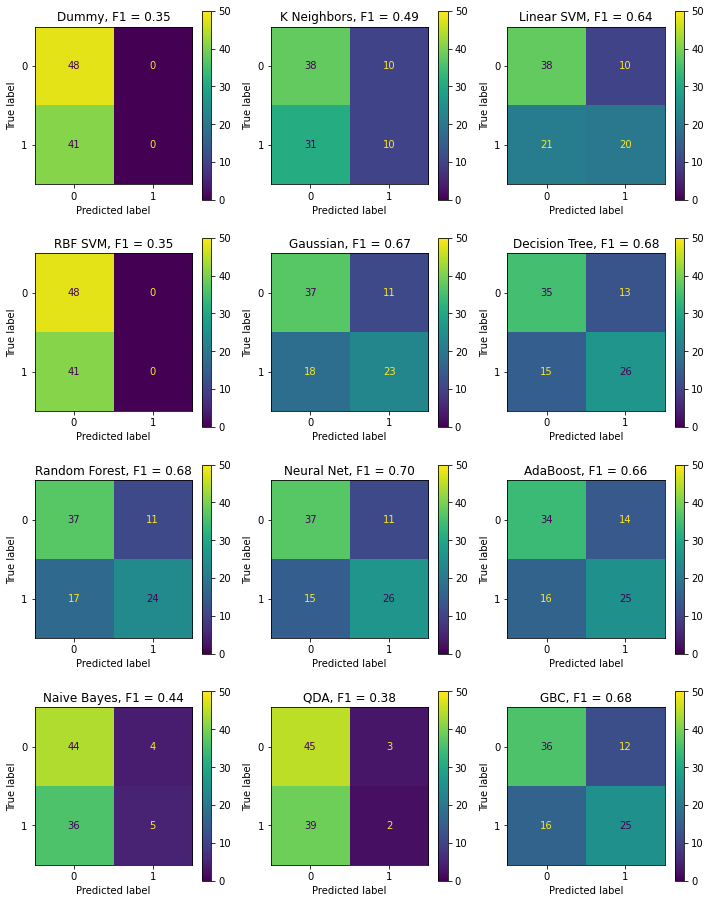

In [14]:
def plot_confusion_matrix_for_models(names, classifiers, nrows, ncols):
    np.random.seed(73246)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 16))
    axis = []
    for ax in axes:
        axis.extend(ax)
    axes_ind = 0
    trained_models = []
    for name, clf in zip(names, classifiers):
        clf.fit(x_train, y_train)
        trained_models.append(clf)
        disp = plot_confusion_matrix(clf, x_test, y_test, ax=axis[axes_ind])
        y_predict = clf.predict(x_test)
        auc_medio = fbeta_score(y_test, y_predict, average='macro', beta=1)
        axis[axes_ind].set_title(f'{name}, F1 = {auc_medio:.2f}')
        disp.im_.set_clim(0, 50)
        axes_ind += 1
    plt.show()
    for ax in axis[len(names):]:
        ax.set_visible(False)
        fig.delaxes(ax)
    return trained_models
_ = plot_confusion_matrix_for_models(names, classifiers, 4, 3)

_Random Forest_ and _Gradient Boost Classifier_ show a good confusion matrix and good scores on AUC metric. Let's check how they perform when the high correlated columns are dropped.

#### Removing highly correlated columns.

In [15]:
data_window02_dropped = data_window02.drop(columns=hcc_window02)
data_window02_dropped

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,POTASSIUM,SAT02_ARTERIAL,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER,HB_ICU
0,True,5,False,False,False,False,False,True,True,False,...,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,1
2,False,0,False,False,False,False,False,False,False,False,...,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,1
3,False,3,True,False,False,False,False,False,False,False,...,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0
4,False,0,False,False,False,False,False,False,False,False,...,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0
5,False,0,False,False,False,False,False,False,False,False,...,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,False,3,True,False,False,False,False,False,False,False,...,-0.629630,0.939394,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,1
381,True,9,False,False,False,False,False,False,False,False,...,-0.518519,0.939394,0.345679,-0.314286,-0.998507,-0.995808,-0.846633,-0.855422,-0.978029,0
382,False,4,False,False,False,False,False,False,False,False,...,-0.407407,0.939394,0.345679,-0.085714,-0.995428,-0.986662,-0.846633,-0.787952,-0.964461,1
383,False,3,True,False,False,False,False,False,False,False,...,-0.555556,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.937349,-0.978029,0


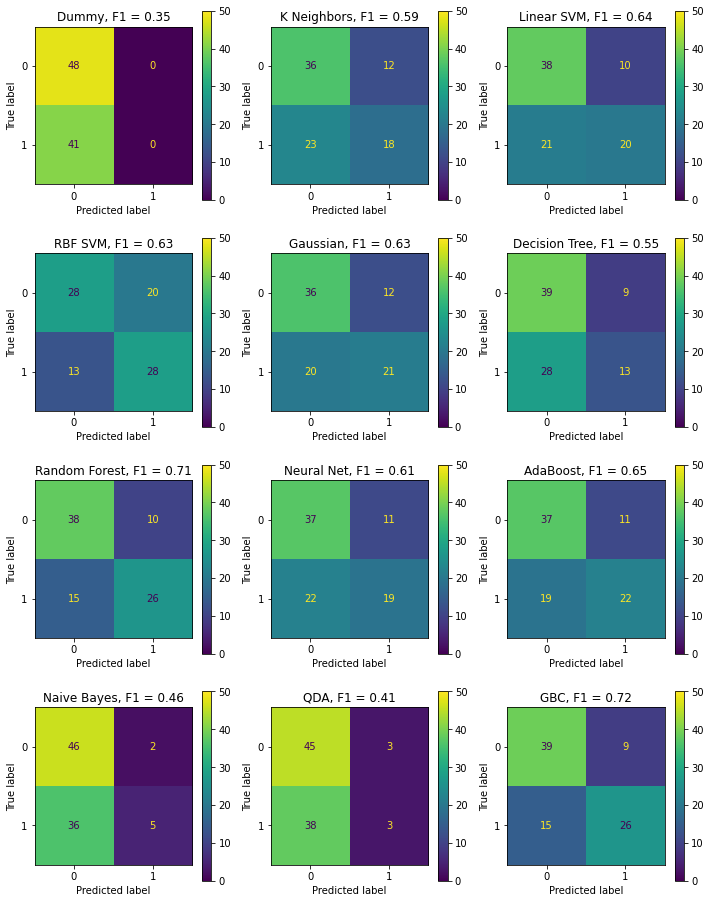

In [16]:
x_columns = data_window02_dropped.columns[:-1]
x = data_window02_dropped[x_columns] # Entrada
y = data_window02_dropped['HB_ICU'] # saida

np.random.seed(73246)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
models = plot_confusion_matrix_for_models(names, classifiers, 4, 3)

The Gradient Boost Classifier's matrix confusion has greatly improved. The False Positive values are the best, followed by Random Forest Classifier.

## Gradient Boost Classifier

### Random Search

/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars


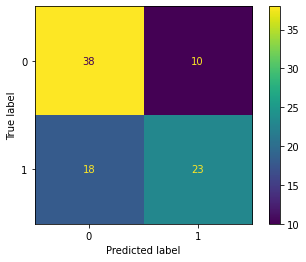

In [17]:
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

gbc_rscv_model = GradientBoostingClassifier()
gbc_rscv_parameters = {
    "learning_rate" : sp_randFloat(0.1, 2.0),
    "max_depth" : sp_randInt(1, 20),
    "max_features" : sp_randFloat(0.01, 1.0),
    "min_samples_leaf" : sp_randInt(1, 30),
    "min_samples_split" : sp_randInt(2, 30),
    "n_estimators" : sp_randInt(100, 400)
}
np.random.seed(73246)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
gbc_rscv = RandomizedSearchCV(gbc_rscv_model, param_distributions=gbc_rscv_parameters,
                              n_iter = 200, cv = cv, scoring=mcc_scorer, n_jobs=5,
                              return_train_score=True)
gbc_rscv.fit(x_train, y_train)

plot_confusion_matrix(gbc_rscv, x_test, y_test)

In [18]:
results = pd.DataFrame(gbc_rscv.cv_results_)
best_index = results.iloc[gbc_rscv.best_index_]
auc_medio = results.iloc[gbc_rscv.best_index_]['mean_test_score']
auc_medio_treino = results.iloc[gbc_rscv.best_index_]['mean_train_score']

auc_std = results.iloc[gbc_rscv.best_index_]['std_test_score']

print(f'AUC  {auc_medio} - {auc_medio_treino}')

AUC  0.49260356909238034 - 1.0


In [19]:
gbc_rscv.best_params_

{'learning_rate': 0.5302915711473221,
 'max_depth': 12,
 'max_features': 0.6049627608747574,
 'min_samples_leaf': 29,
 'min_samples_split': 2,
 'n_estimators': 361}

### GBC Manually found 

F1: 0.6946050284477557
             precision    recall  f1-score  support
0                 0.72      0.75  0.734694       48
1             0.692308  0.658537  0.675000       41
accuracy                          0.707865       89
macro avg     0.706154  0.704268  0.704847       89
weighted avg  0.707243  0.707865  0.707194       89


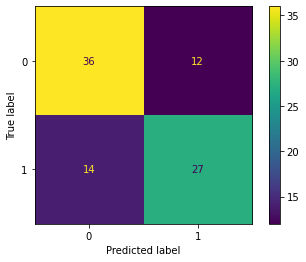

In [20]:
# Found manually
# clf = GradientBoostingClassifier(learning_rate=0.7, max_depth=12, max_features=0.3, min_samples_leaf=5, min_samples_split=6, n_estimators=260, subsample=1.0)
clf = GradientBoostingClassifier(learning_rate=0.5, max_depth=8, max_features=0.4, min_samples_leaf=3, min_samples_split=17, n_estimators=100, subsample=1.0)

model_manual = train_evaluate_classifier(clf, x, y, x_train, y_train, x_test, y_test)

### ROC Curve for GBC

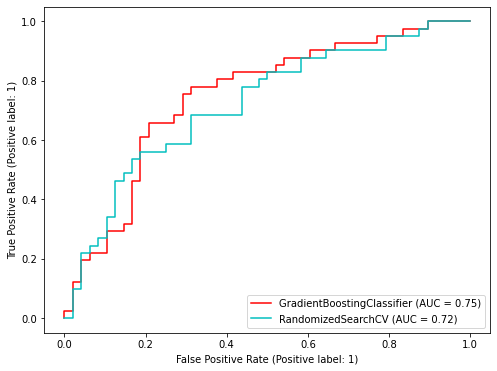

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plot_roc_curve(model_manual, x_test, y_test, ax=ax, color='r')
plot_roc_curve(gbc_rscv, x_test, y_test, ax=ax, color='c')

## Random Forest

### Radom Search

In [22]:
np.random.seed(73246)
rfc_rscv_model = RandomForestClassifier()
rfc_rscv_parameters = {
    "n_estimators" : sp_randInt(100, 400),
    "criterion" : ['gini', 'entropy'],
    "max_depth" : sp_randInt(1, 20),
    "min_samples_split" : sp_randInt(2, 30),
    "min_samples_leaf" : sp_randInt(1, 30),
    "max_features" : sp_randFloat(0.01, 1.0),
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
rfc_rscv = RandomizedSearchCV(rfc_rscv_model, param_distributions=rfc_rscv_parameters,
                              n_iter = 200, cv = cv, scoring=mcc_scorer, n_jobs=5,
                              return_train_score=True)
rfc_rscv.fit(x_train, y_train)

/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None),
                   estimator=RandomForestClassifier(), n_iter=200, n_jobs=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfcb296c90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfc67da490>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfc67da610>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfc6357350>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfcb2cff50>},
                   return_train_score=True,
                   scoring=make_scorer(matthews_corrcoef))

In [23]:
rfc_rscv.best_params_

{'criterion': 'entropy',
 'max_depth': 17,
 'max_features': 0.05448254926519657,
 'min_samples_leaf': 2,
 'min_samples_split': 18,
 'n_estimators': 217}

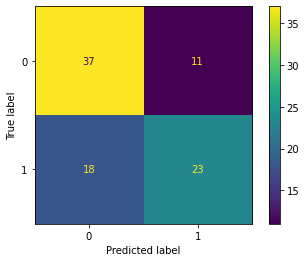

In [24]:
# train_evaluate_classifier(rfc_rscv, x, y, x_train, y_train, x_test, y_test, skip_fit = True)
plot_confusion_matrix(rfc_rscv, x_test, y_test)

In [25]:
# clf = RandomForestClassifier(criterion='gini', max_depth=10, max_features=0.20274648540878437, min_samples_leaf=5, min_samples_split=16, n_estimators=365)
# rfc_rscv_best = train_evaluate_classifier(clf, x, y, x_train, y_train, x_test, y_test)

### Previous Random Search

F1: 0.704910776232045
             precision    recall  f1-score  support
0                 0.75    0.8125  0.780000       48
1             0.756757  0.682927  0.717949       41
accuracy                          0.752809       89
macro avg     0.753378  0.747713  0.748974       89
weighted avg  0.753113  0.752809  0.751415       89


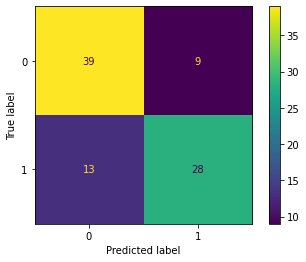

In [38]:
clf = RandomForestClassifier(criterion='gini', max_depth=6, max_features=0.30034845148359435, min_samples_leaf=6, min_samples_split=10, n_estimators=185)
rfc_rscv_best = train_evaluate_classifier(clf, x, y, x_train, y_train, x_test, y_test)

## Gradient Boost Classifier vs Random Forest

In [27]:
def format_classification_report(test, predict):
    df_cr = pd.DataFrame(classification_report(test, predict, output_dict=True)).T
    df_cr['precision']['accuracy'] = ''
    df_cr['recall']['accuracy'] = ''
    df_cr['support']['accuracy'] = df_cr['support']['macro avg']
    df_cr['support'] = df_cr['support'].astype('int32')
    return df_cr

rfc_model = models[6]
gbc_model = models[11]

y_predict_rfc = rfc_model.predict(x_test)
y_predict_gbc = gbc_model.predict(x_test)

df_rfc = format_classification_report(y_test, y_predict_rfc)
df_gbc = format_classification_report(y_test, y_predict_gbc)

pd.concat([df_rfc, df_gbc], axis=1, keys=['Random Forest Classifier', 'Gradient Boost Classifier'])

Random Forest Classifier                              \
                            precision    recall  f1-score support   
0                            0.716981  0.791667  0.752475      48   
1                            0.722222  0.634146  0.675325      41   
accuracy                                         0.719101      89   
macro avg                    0.719602  0.712907  0.713900      89   
weighted avg                 0.719396  0.719101  0.716934      89   

             Gradient Boost Classifier                              
                             precision    recall  f1-score support  
0                             0.722222    0.8125  0.764706      48  
1                             0.742857  0.634146  0.684211      41  
accuracy                                          0.730337      89  
macro avg                      0.73254  0.723323  0.724458      89  
weighted avg                  0.731728  0.730337  0.727624      89

In [35]:
y_predict_rscv_best = rfc_rscv_best.predict(x_test)
y_predict_model_manual = model_manual.predict(x_test)

df_rscv_best = format_classification_report(y_test, y_predict_rscv_best)
df_model_manual = format_classification_report(y_test, y_predict_model_manual)

pd.concat([df_rscv_best, df_model_manual], axis=1, keys=['Random Forest Classifier - Best', 'Gradient Boost Classifier - Manual'])

Random Forest Classifier - Best                              \
                                   precision    recall  f1-score support   
0                                       0.75    0.8125  0.780000      48   
1                                   0.756757  0.682927  0.717949      41   
accuracy                                                0.752809      89   
macro avg                           0.753378  0.747713  0.748974      89   
weighted avg                        0.753113  0.752809  0.751415      89   

             Gradient Boost Classifier - Manual                              
                                      precision    recall  f1-score support  
0                                          0.72      0.75  0.734694      48  
1                                      0.692308  0.658537  0.675000      41  
accuracy                                                   0.707865      89  
macro avg                              0.706154  0.704268  0.704847      89  
weighted avg                           0.707243  0.707865  0.707194      89

In [28]:
print(fbeta_score(y_test, y_predict_gbc, average='macro', beta=2))

0.72297462924378


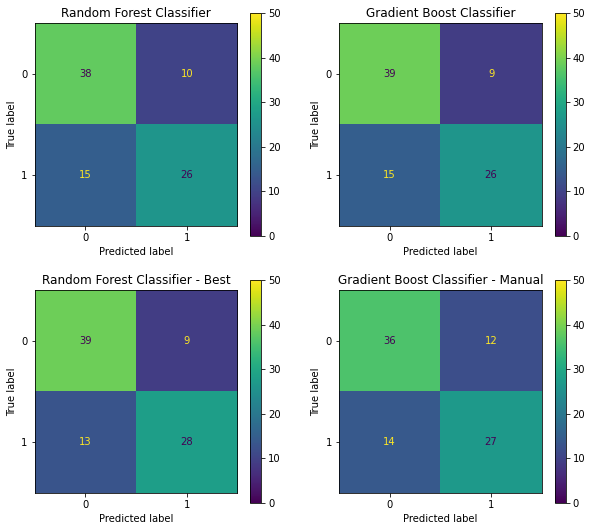

In [36]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))

disp = plot_confusion_matrix(rfc_model, x_test, y_test, ax=ax11)
disp.im_.set_clim(0, 50)
ax11.set_title('Random Forest Classifier')

disp = plot_confusion_matrix(gbc_model, x_test, y_test, ax=ax12)
disp.im_.set_clim(0, 50)
ax12.set_title('Gradient Boost Classifier')

disp = plot_confusion_matrix(rfc_rscv_best, x_test, y_test, ax=ax21)
disp.im_.set_clim(0, 50)
ax21.set_title('Random Forest Classifier - Best')

disp = plot_confusion_matrix(model_manual, x_test, y_test, ax=ax22)
disp.im_.set_clim(0, 50)
ax22.set_title('Gradient Boost Classifier - Manual')
plt.show()

# Shap

In [30]:
import shap
y_predict = rfc_rscv_best.predict(x_test)

In [31]:
idx = 12

explainer = shap.TreeExplainer(rfc_rscv_best)
shap.initjs()

choosen_instance = x_test.iloc[idx]
shap_values = explainer.shap_values(choosen_instance)
print(f'Ground Truth: {y_test.iloc[idx]}')
print(f'Predicted: {y_predict[idx]}')
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)
# shap.plots.waterfall(shap_values[0])

Ground Truth: 1
Predicted: 0


In [32]:
idx = 1
choosen_instance = x_test.iloc[idx]
shap_values = explainer.shap_values(choosen_instance)
print(f'Ground Truth: {y_test.iloc[idx]}')
print(f'Predicted: {y_predict[idx]}')
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Ground Truth: 1
Predicted: 0


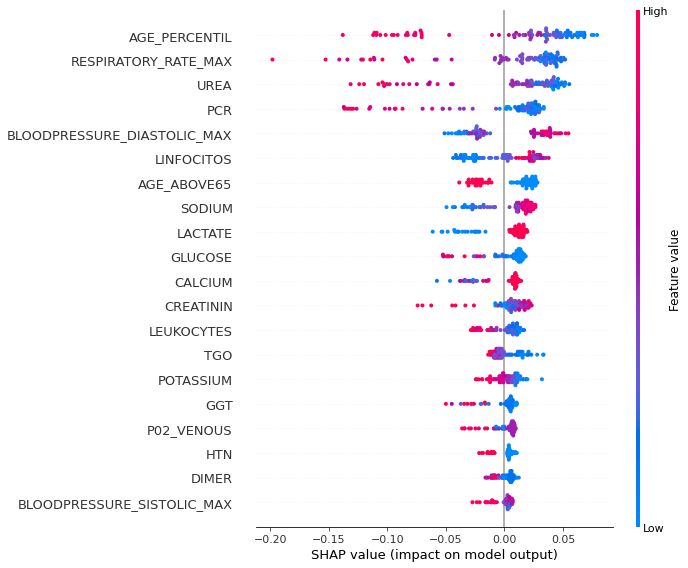

/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars


In [33]:
explainer = shap.TreeExplainer(rfc_rscv_best)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values[0], x_test, plot_type="dot")